# Speech Emotion Recognition Version 2

In [77]:
import os
import random
import sys

In [78]:
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)

In [79]:
from keras import regularizers
from keras.callbacks import  History
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

In [81]:
dir_list = os.listdir('data/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [82]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                             'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
       # if nm[3] == '01':
        #    intensity = 0
        #else:
         #   intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, statement, repeat, emotion]
        count += 1

In [83]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,statement,repetition,emotion
0,data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,1
1,data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,1,1
2,data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,1,0,1
3,data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,1,1,1
4,data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,2


In [84]:

filename = data_df.path[121]
print (filename)
#print ("samyak")
samples, sample_rate = librosa.load(filename)
sample_rate, samples

data/Actor_03/03-01-01-01-01-02-03.wav


(22050, array([-6.0700299e-06, -3.5395646e-05, -2.4951731e-05, ...,
        -1.4991684e-05, -7.3881201e-06,  0.0000000e+00], dtype=float32))

In [85]:

len(samples), sample_rate

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [86]:
sample_rate/ len(samples)

0.285425808706458

In [87]:
label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [88]:

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [89]:
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [90]:
label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [91]:

data_df['label'] = label2_list
#data_df['label'] = label3_list
#data_df['label'] = label5_list
#data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,statement,repetition,emotion,label
0,data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,1,male_none
1,data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,1,1,male_none
2,data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,1,0,1,male_none
3,data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,1,1,1,male_none
4,data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,2,male_positive


In [92]:
print (data_df.label.value_counts().keys())


Index(['male_negative', 'female_negative', 'female_none', 'male_none',
       'female_positive', 'male_positive'],
      dtype='object')


In [93]:

# def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
#     """
#     To plot the data distributioin by class.
#     Arg:
#       dist: pandas series of label count. 
#     """
#     tmp_df = pd.DataFrame()
#     tmp_df['Emotion'] = list(dist.keys())
#     tmp_df['Count'] = list(dist)
#     fig, ax = plt.subplots(figsize=(14, 7))
#     ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
#     ax.set_title(title)
#     ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

In [94]:
# a = data_df.label.value_counts()
# plot_emotion_dist(a, "#2962FF", "Emotion Distribution")


In [95]:
data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,actor,gender,statement,repetition,emotion,label
0,data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,2,male_positive
1,data/Actor_01/03-01-02-01-01-02-01.wav,1,1,male,0,1,2,male_positive
2,data/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,1,0,2,male_positive
3,data/Actor_01/03-01-02-01-02-02-01.wav,1,1,male,1,1,2,male_positive
4,data/Actor_01/03-01-02-02-01-01-01.wav,1,1,male,0,0,2,male_positive


In [96]:
print (len(data3_df))
data3_df.head()

80


,path,source,actor,gender,statement,repetition,emotion,label
0,data/Actor_21/03-01-02-01-01-01-21.wav,1,21,male,0,0,2,male_positive
1,data/Actor_21/03-01-02-01-01-02-21.wav,1,21,male,0,1,2,male_positive
2,data/Actor_21/03-01-02-01-02-01-21.wav,1,21,male,1,0,2,male_positive
3,data/Actor_21/03-01-02-01-02-02-21.wav,1,21,male,1,1,2,male_positive
4,data/Actor_21/03-01-02-02-01-01-21.wav,1,21,male,0,0,2,male_positive


In [97]:

data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 400/400 [00:14<00:00, 27.53it/s]


In [98]:
mfccs.shape

(259,)

In [22]:

data.head()

,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-67.55739, -67.55739, -67.55739, -67.55739, -..."
2,"[-69.67329, -69.693306, -69.693306, -69.693306..."
3,"[-69.0514, -69.0514, -69.0514, -69.0514, -69.0..."
4,"[-73.84137, -73.84137, -73.84137, -73.71965, -..."


In [23]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769
1,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388
2,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306
3,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-65.446953,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,NaN,NaN,NaN
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370


In [24]:
newdf = pd.concat([df3,labels], axis=1)

In [25]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_positive
1,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_positive
2,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_positive
3,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,NaN,NaN,NaN,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive
5,-69.243256,-69.243256,-69.243256,-69.243256,-68.901970,-67.983002,-68.089203,-67.897331,-65.258011,-67.170975,...,-57.185970,-61.188725,-67.108391,-67.508125,-66.245537,-68.733047,-69.243256,-69.243256,-69.243256,male_positive
6,-73.254967,-73.254967,-73.254967,-73.254967,-68.774429,-69.380402,-73.254967,-73.254967,-73.254967,-73.254967,...,-50.884079,-55.666733,-54.600002,-53.439114,-56.300125,-57.458267,-58.767071,-59.836510,-58.409870,male_positive
7,-70.746513,-70.746513,-70.025284,-69.131271,-70.746513,-70.746513,-70.746513,-70.746513,-70.746513,-70.746513,...,-70.746513,-70.746513,-70.079247,-69.590454,-69.202751,-70.159462,-70.445366,-68.199043,-67.414200,male_positive
8,-63.311062,-63.072487,-63.412422,-63.796757,-63.581989,-58.921223,-57.955044,-61.224972,-63.782932,-63.796757,...,-63.740608,-62.410255,-62.489079,-62.494453,-62.632626,-62.824276,NaN,NaN,NaN,male_positive
9,-60.369045,-60.083717,-60.978924,-60.952457,-60.982483,-60.983948,-60.981255,-60.981255,-60.981255,-60.249615,...,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,NaN,NaN,NaN,male_positive


In [26]:
rnewdf.isnull().sum().sum()

rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_positive
1,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_positive
2,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_positive
3,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,0.000000,0.000000,0.000000,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive


In [27]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

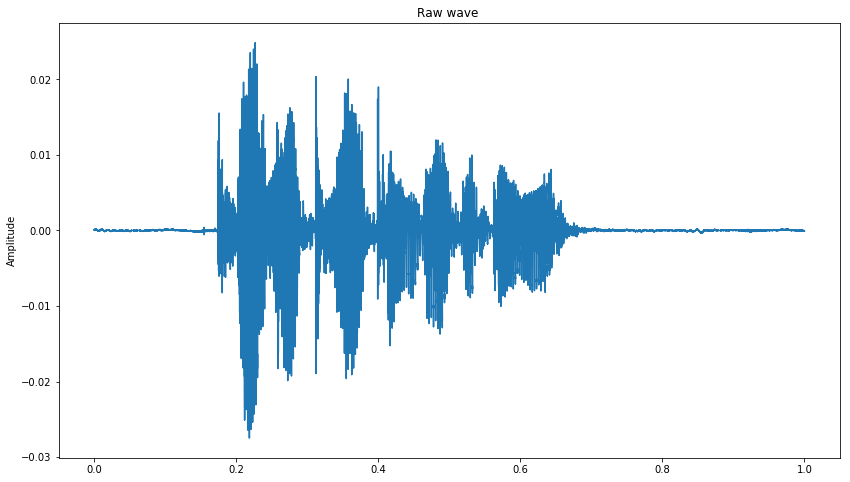

In [28]:

X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

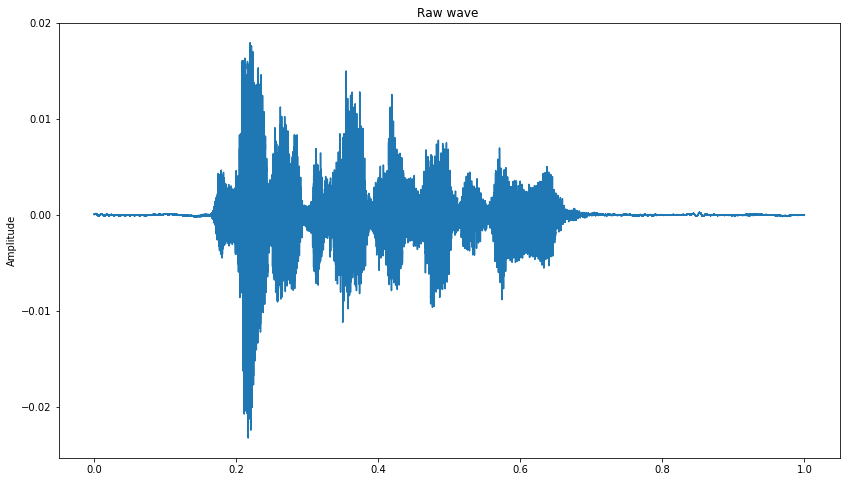

In [29]:

x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [30]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [00:16<00:00, 23.51it/s]


In [53]:
mfccs.shape

(259,)

In [31]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [01:15<00:00,  5.11it/s]


In [32]:
len(syn_data1), len(syn_data2)

(400, 400)

In [33]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [34]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-58.206749,-55.749172,-55.094097,-58.077942,-59.965324,-60.338055,-59.059612,-54.831863,-54.266373,-56.149399,...,-56.376968,-56.422245,-58.023674,-57.493351,-57.761662,-58.468845,-57.723019,-58.953934,-57.524841,male_positive
1,-54.707405,-54.768959,-55.891453,-54.833084,-57.632000,-56.500813,-53.743435,-53.149773,-54.777317,-55.058212,...,-55.916523,-57.212181,-54.268215,-55.214191,-55.300686,-56.631897,-53.749283,-55.502850,-53.762589,male_positive
2,-69.284828,-68.763336,-69.686821,-69.682625,-69.693512,-69.693512,-69.713081,-69.725800,-69.693512,-68.940659,...,-69.693512,-69.693512,-69.693512,-69.697075,-68.967804,-69.450027,-69.561897,-69.693512,-69.693512,male_positive
3,-57.208927,-56.159134,-56.550621,-56.630417,-55.766487,-55.059998,-56.869766,-54.332504,-52.623589,-54.659172,...,-55.368912,-55.915054,-55.888096,-54.083721,-55.863178,-55.708370,0.000000,0.000000,0.000000,male_positive
4,-58.009464,-56.925838,-61.090446,-61.339859,-59.064537,-57.405273,-59.763191,-61.837807,-61.975388,-60.467075,...,-60.219219,-59.739605,-57.883980,-57.858372,-61.081856,-58.157017,-58.688023,-59.592369,-57.991776,male_positive


In [35]:

df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

syndf2.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-71.092476,-71.092476,-71.092476,-71.092476,-71.092476,-71.092476,-71.092476,-71.092476,-71.092476,-71.092476,...,-71.092476,-70.898605,-70.830894,-70.779060,-71.069603,-71.023300,-70.786835,-71.092476,-71.092476,male_positive
1,-70.534630,-70.534630,-70.511139,-70.534630,-70.534630,-69.789101,-69.337868,-70.335907,-70.534630,-70.534630,...,-70.534630,-70.534630,-70.534630,-70.534630,-70.534630,-70.534630,-70.400139,-69.654121,-70.534630,male_positive
2,-71.282516,-71.344063,-71.754143,-71.754143,-71.754143,-71.754143,-71.754143,-71.754143,-71.754143,-70.753822,...,-71.754143,-71.754143,-71.754143,-71.754143,-71.754143,-71.754143,-71.754143,-71.754143,-71.754143,male_positive
3,-69.884552,-69.884552,-69.884552,-69.884552,-69.884552,-69.884552,-69.884552,-69.884552,-69.884552,-69.884552,...,-69.526909,-69.884552,-69.884552,-69.884552,-69.884552,-69.884552,0.000000,0.000000,0.000000,male_positive
4,-74.693588,-74.693588,-74.688530,-74.693588,-74.693588,-74.693588,-74.693588,-74.454514,-74.505119,-74.693588,...,-74.693588,-74.693588,-74.693588,-74.693588,-74.693588,-74.693588,-74.693588,-74.693588,-74.693588,male_positive


In [36]:

combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_positive
1,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_positive
2,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_positive
3,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,0.000000,0.000000,0.000000,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive


In [37]:
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [38]:
y_train.value_counts()

male_negative    576
male_positive    384
Name: label, dtype: int64

In [39]:

y_test.value_counts()

male_negative    144
male_positive     96
Name: label, dtype: int64

In [40]:
X_train.isna().sum().sum()

0

In [41]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [42]:
y_train

X_train.shape

(960, 259)

In [43]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [44]:

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [45]:
model = Sequential()
model.add(Conv1D(256, 2,padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 2,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 2,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 2,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 2,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 2,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

W0510 19:06:14.123137 13600 deprecation_wrapper.py:119] From C:\Users\samya\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          768       
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 128)          65664     
_________________________________________________________________
activation_2 (Activation)    (None, 259, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 128)          

In [47]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [48]:
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
#mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=400)

W0510 19:06:25.776410 13600 deprecation_wrapper.py:119] From C:\Users\samya\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/400
960/960 [==============================] - ETA: 12s - loss: 0.6291 - accuracy: 0.7188 - fscore: 0.71 - ETA: 7s - loss: 0.7187 - accuracy: 0.5938 - fscore: 0.5937 - ETA: 5s - loss: 0.7189 - accuracy: 0.5729 - fscore: 0.572 - ETA: 4s - loss: 0.6640 - accuracy: 0.6406 - fscore: 0.640 - ETA: 3s - loss: 0.6665 - accuracy: 0.6250 - fscore: 0.625 - ETA: 3s - loss: 0.6809 - accuracy: 0.6146 - fscore: 0.614 - ETA: 2s - loss: 0.6728 - accuracy: 0.6205 - fscore: 0.620 - ETA: 2s - loss: 0.6772 - accuracy: 0.6133 - fscore: 0.613 - ETA: 2s - loss: 0.6911 - accuracy: 0.6076 - fscore: 0.607 - ETA: 1s - loss: 0.6831 - accuracy: 0.6156 - fscore: 0.615 - ETA: 1s - loss: 0.6844 - accuracy: 0.6222 - fscore: 0.622 - ETA: 1s - loss: 0.6931 - accuracy: 0.6068 - fscore: 0.606 - ETA: 1s - loss: 0.6980 - accuracy: 0.6058 - fscore: 0.605 - ETA: 1s - loss: 0.7018 - accuracy: 0.6027 - fscore: 0.602 - ETA: 1s - loss: 0.7009 - accuracy: 0.5979 - fscore: 0.597 - ETA: 1s - loss: 0.7002 - accuracy: 0.5977 - 

960/960 [==============================] - ETA: 1s - loss: 0.7412 - accuracy: 0.4688 - fscore: 0.468 - ETA: 1s - loss: 0.6776 - accuracy: 0.5781 - fscore: 0.578 - ETA: 1s - loss: 0.6727 - accuracy: 0.6094 - fscore: 0.609 - ETA: 1s - loss: 0.6839 - accuracy: 0.5833 - fscore: 0.583 - ETA: 1s - loss: 0.6788 - accuracy: 0.5893 - fscore: 0.589 - ETA: 1s - loss: 0.6823 - accuracy: 0.5859 - fscore: 0.585 - ETA: 1s - loss: 0.6811 - accuracy: 0.5833 - fscore: 0.583 - ETA: 1s - loss: 0.6930 - accuracy: 0.5688 - fscore: 0.568 - ETA: 1s - loss: 0.6942 - accuracy: 0.5625 - fscore: 0.562 - ETA: 1s - loss: 0.6928 - accuracy: 0.5651 - fscore: 0.565 - ETA: 1s - loss: 0.6938 - accuracy: 0.5625 - fscore: 0.562 - ETA: 0s - loss: 0.7002 - accuracy: 0.5558 - fscore: 0.555 - ETA: 0s - loss: 0.6987 - accuracy: 0.5604 - fscore: 0.560 - ETA: 0s - loss: 0.7000 - accuracy: 0.5625 - fscore: 0.562 - ETA: 0s - loss: 0.7004 - accuracy: 0.5607 - fscore: 0.560 - ETA: 0s - loss: 0.6998 - accuracy: 0.5590 - fscore: 0.559

960/960 [==============================] - ETA: 1s - loss: 0.6384 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.6765 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1s - loss: 0.6734 - accuracy: 0.6146 - fscore: 0.614 - ETA: 1s - loss: 0.6687 - accuracy: 0.6328 - fscore: 0.632 - ETA: 1s - loss: 0.6827 - accuracy: 0.6000 - fscore: 0.600 - ETA: 1s - loss: 0.6813 - accuracy: 0.6042 - fscore: 0.604 - ETA: 1s - loss: 0.6860 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1s - loss: 0.6792 - accuracy: 0.5972 - fscore: 0.597 - ETA: 1s - loss: 0.6810 - accuracy: 0.5881 - fscore: 0.588 - ETA: 1s - loss: 0.6800 - accuracy: 0.5833 - fscore: 0.583 - ETA: 1s - loss: 0.6745 - accuracy: 0.5938 - fscore: 0.593 - ETA: 0s - loss: 0.6745 - accuracy: 0.5871 - fscore: 0.587 - ETA: 0s - loss: 0.6728 - accuracy: 0.5879 - fscore: 0.587 - ETA: 0s - loss: 0.6740 - accuracy: 0.5864 - fscore: 0.586 - ETA: 0s - loss: 0.6794 - accuracy: 0.5764 - fscore: 0.576 - ETA: 0s - loss: 0.6764 - accuracy: 0.5773 - fscore: 0.577

960/960 [==============================] - ETA: 2s - loss: 0.7138 - accuracy: 0.4062 - fscore: 0.406 - ETA: 2s - loss: 0.7009 - accuracy: 0.4688 - fscore: 0.468 - ETA: 2s - loss: 0.6645 - accuracy: 0.5417 - fscore: 0.541 - ETA: 2s - loss: 0.6697 - accuracy: 0.5391 - fscore: 0.539 - ETA: 1s - loss: 0.6693 - accuracy: 0.5625 - fscore: 0.562 - ETA: 1s - loss: 0.6623 - accuracy: 0.5677 - fscore: 0.567 - ETA: 1s - loss: 0.6607 - accuracy: 0.5759 - fscore: 0.575 - ETA: 1s - loss: 0.6630 - accuracy: 0.5703 - fscore: 0.570 - ETA: 1s - loss: 0.6662 - accuracy: 0.5764 - fscore: 0.576 - ETA: 1s - loss: 0.6738 - accuracy: 0.5625 - fscore: 0.562 - ETA: 1s - loss: 0.6744 - accuracy: 0.5653 - fscore: 0.565 - ETA: 1s - loss: 0.6737 - accuracy: 0.5703 - fscore: 0.570 - ETA: 1s - loss: 0.6702 - accuracy: 0.5721 - fscore: 0.572 - ETA: 1s - loss: 0.6690 - accuracy: 0.5714 - fscore: 0.571 - ETA: 1s - loss: 0.6652 - accuracy: 0.5771 - fscore: 0.577 - ETA: 0s - loss: 0.6646 - accuracy: 0.5820 - fscore: 0.582

960/960 [==============================] - ETA: 1s - loss: 0.6347 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.6605 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1s - loss: 0.6864 - accuracy: 0.5521 - fscore: 0.552 - ETA: 1s - loss: 0.6729 - accuracy: 0.6094 - fscore: 0.609 - ETA: 1s - loss: 0.6660 - accuracy: 0.6125 - fscore: 0.612 - ETA: 1s - loss: 0.6608 - accuracy: 0.6146 - fscore: 0.614 - ETA: 1s - loss: 0.6570 - accuracy: 0.6205 - fscore: 0.620 - ETA: 1s - loss: 0.6578 - accuracy: 0.6172 - fscore: 0.617 - ETA: 1s - loss: 0.6547 - accuracy: 0.6215 - fscore: 0.621 - ETA: 1s - loss: 0.6600 - accuracy: 0.6219 - fscore: 0.621 - ETA: 1s - loss: 0.6594 - accuracy: 0.6222 - fscore: 0.622 - ETA: 1s - loss: 0.6580 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1s - loss: 0.6636 - accuracy: 0.6202 - fscore: 0.620 - ETA: 0s - loss: 0.6591 - accuracy: 0.6295 - fscore: 0.629 - ETA: 0s - loss: 0.6579 - accuracy: 0.6292 - fscore: 0.629 - ETA: 0s - loss: 0.6560 - accuracy: 0.6328 - fscore: 0.632

960/960 [==============================] - ETA: 1s - loss: 0.6637 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1s - loss: 0.6544 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1s - loss: 0.6555 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1s - loss: 0.6368 - accuracy: 0.6406 - fscore: 0.640 - ETA: 1s - loss: 0.6585 - accuracy: 0.6062 - fscore: 0.606 - ETA: 1s - loss: 0.6625 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1s - loss: 0.6521 - accuracy: 0.6071 - fscore: 0.607 - ETA: 1s - loss: 0.6539 - accuracy: 0.6094 - fscore: 0.609 - ETA: 1s - loss: 0.6489 - accuracy: 0.6111 - fscore: 0.611 - ETA: 1s - loss: 0.6422 - accuracy: 0.6313 - fscore: 0.631 - ETA: 1s - loss: 0.6444 - accuracy: 0.6307 - fscore: 0.630 - ETA: 1s - loss: 0.6454 - accuracy: 0.6302 - fscore: 0.630 - ETA: 1s - loss: 0.6467 - accuracy: 0.6250 - fscore: 0.625 - ETA: 0s - loss: 0.6550 - accuracy: 0.6138 - fscore: 0.613 - ETA: 0s - loss: 0.6602 - accuracy: 0.6042 - fscore: 0.604 - ETA: 0s - loss: 0.6571 - accuracy: 0.6113 - fscore: 0.611

960/960 [==============================] - ETA: 1s - loss: 0.5731 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.6330 - accuracy: 0.6406 - fscore: 0.640 - ETA: 1s - loss: 0.6644 - accuracy: 0.5729 - fscore: 0.572 - ETA: 1s - loss: 0.6580 - accuracy: 0.6172 - fscore: 0.617 - ETA: 1s - loss: 0.6532 - accuracy: 0.6375 - fscore: 0.637 - ETA: 1s - loss: 0.6532 - accuracy: 0.6458 - fscore: 0.645 - ETA: 1s - loss: 0.6446 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.6511 - accuracy: 0.6367 - fscore: 0.636 - ETA: 1s - loss: 0.6469 - accuracy: 0.6424 - fscore: 0.642 - ETA: 1s - loss: 0.6446 - accuracy: 0.6469 - fscore: 0.646 - ETA: 1s - loss: 0.6518 - accuracy: 0.6420 - fscore: 0.642 - ETA: 1s - loss: 0.6495 - accuracy: 0.6432 - fscore: 0.643 - ETA: 1s - loss: 0.6448 - accuracy: 0.6514 - fscore: 0.651 - ETA: 1s - loss: 0.6475 - accuracy: 0.6496 - fscore: 0.649 - ETA: 0s - loss: 0.6498 - accuracy: 0.6417 - fscore: 0.641 - ETA: 0s - loss: 0.6490 - accuracy: 0.6406 - fscore: 0.640

960/960 [==============================] - ETA: 1s - loss: 0.6130 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.6265 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.6236 - accuracy: 0.6979 - fscore: 0.697 - ETA: 1s - loss: 0.6228 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.6266 - accuracy: 0.6750 - fscore: 0.675 - ETA: 1s - loss: 0.6272 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.6226 - accuracy: 0.6786 - fscore: 0.678 - ETA: 1s - loss: 0.6248 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1s - loss: 0.6242 - accuracy: 0.6701 - fscore: 0.670 - ETA: 1s - loss: 0.6279 - accuracy: 0.6625 - fscore: 0.662 - ETA: 1s - loss: 0.6265 - accuracy: 0.6619 - fscore: 0.661 - ETA: 1s - loss: 0.6249 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.6256 - accuracy: 0.6587 - fscore: 0.658 - ETA: 1s - loss: 0.6269 - accuracy: 0.6562 - fscore: 0.656 - ETA: 0s - loss: 0.6251 - accuracy: 0.6625 - fscore: 0.662 - ETA: 0s - loss: 0.6205 - accuracy: 0.6641 - fscore: 0.664

960/960 [==============================] - ETA: 1s - loss: 0.6568 - accuracy: 0.5312 - fscore: 0.531 - ETA: 1s - loss: 0.6243 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1s - loss: 0.6287 - accuracy: 0.6354 - fscore: 0.635 - ETA: 1s - loss: 0.6073 - accuracy: 0.6953 - fscore: 0.695 - ETA: 1s - loss: 0.5994 - accuracy: 0.7063 - fscore: 0.706 - ETA: 1s - loss: 0.5978 - accuracy: 0.7135 - fscore: 0.713 - ETA: 1s - loss: 0.6038 - accuracy: 0.7054 - fscore: 0.705 - ETA: 1s - loss: 0.6059 - accuracy: 0.6992 - fscore: 0.699 - ETA: 1s - loss: 0.6096 - accuracy: 0.6910 - fscore: 0.691 - ETA: 1s - loss: 0.6109 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.6063 - accuracy: 0.7017 - fscore: 0.701 - ETA: 1s - loss: 0.6074 - accuracy: 0.6953 - fscore: 0.695 - ETA: 1s - loss: 0.6096 - accuracy: 0.6947 - fscore: 0.694 - ETA: 1s - loss: 0.6090 - accuracy: 0.6964 - fscore: 0.696 - ETA: 0s - loss: 0.6131 - accuracy: 0.6875 - fscore: 0.687 - ETA: 0s - loss: 0.6141 - accuracy: 0.6895 - fscore: 0.689

960/960 [==============================] - ETA: 1s - loss: 0.6660 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1s - loss: 0.6371 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1s - loss: 0.6387 - accuracy: 0.6771 - fscore: 0.677 - ETA: 1s - loss: 0.6216 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.6203 - accuracy: 0.6687 - fscore: 0.668 - ETA: 1s - loss: 0.6115 - accuracy: 0.6771 - fscore: 0.677 - ETA: 1s - loss: 0.6149 - accuracy: 0.6786 - fscore: 0.678 - ETA: 1s - loss: 0.6196 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1s - loss: 0.6150 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1s - loss: 0.6171 - accuracy: 0.6648 - fscore: 0.664 - ETA: 1s - loss: 0.6222 - accuracy: 0.6589 - fscore: 0.658 - ETA: 1s - loss: 0.6184 - accuracy: 0.6635 - fscore: 0.663 - ETA: 0s - loss: 0.6201 - accuracy: 0.6607 - fscore: 0.660 - ETA: 0s - loss: 0.6172 - accuracy: 0.6687 - fscore: 0.668 - ETA: 0s - loss: 0.6174 - accuracy: 0.6680 - fscore: 0.668 - ETA: 0s - loss: 0.6160 - accuracy: 0.6691 - fscore: 0.669

960/960 [==============================] - ETA: 1s - loss: 0.5681 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.6277 - accuracy: 0.6406 - fscore: 0.640 - ETA: 1s - loss: 0.6618 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1s - loss: 0.6148 - accuracy: 0.6438 - fscore: 0.643 - ETA: 1s - loss: 0.6201 - accuracy: 0.6429 - fscore: 0.642 - ETA: 1s - loss: 0.6224 - accuracy: 0.6406 - fscore: 0.640 - ETA: 1s - loss: 0.6146 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.6107 - accuracy: 0.6594 - fscore: 0.659 - ETA: 1s - loss: 0.6113 - accuracy: 0.6619 - fscore: 0.661 - ETA: 1s - loss: 0.6128 - accuracy: 0.6615 - fscore: 0.661 - ETA: 1s - loss: 0.6112 - accuracy: 0.6707 - fscore: 0.670 - ETA: 0s - loss: 0.6073 - accuracy: 0.6741 - fscore: 0.674 - ETA: 0s - loss: 0.6108 - accuracy: 0.6708 - fscore: 0.670 - ETA: 0s - loss: 0.6134 - accuracy: 0.6680 - fscore: 0.668 - ETA: 0s - loss: 0.6130 - accuracy: 0.6654 - fscore: 0.665 - ETA: 0s - loss: 0.6129 - accuracy: 0.6667 - fscore: 0.666

960/960 [==============================] - ETA: 1s - loss: 0.6291 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.6331 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1s - loss: 0.5944 - accuracy: 0.7396 - fscore: 0.739 - ETA: 1s - loss: 0.5803 - accuracy: 0.7422 - fscore: 0.742 - ETA: 1s - loss: 0.5735 - accuracy: 0.7437 - fscore: 0.743 - ETA: 1s - loss: 0.5970 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1s - loss: 0.5871 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5982 - accuracy: 0.7070 - fscore: 0.707 - ETA: 1s - loss: 0.5947 - accuracy: 0.7153 - fscore: 0.715 - ETA: 1s - loss: 0.5867 - accuracy: 0.7219 - fscore: 0.721 - ETA: 1s - loss: 0.5888 - accuracy: 0.7216 - fscore: 0.721 - ETA: 1s - loss: 0.5966 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1s - loss: 0.5964 - accuracy: 0.6995 - fscore: 0.699 - ETA: 1s - loss: 0.5892 - accuracy: 0.7076 - fscore: 0.707 - ETA: 1s - loss: 0.5897 - accuracy: 0.7104 - fscore: 0.710 - ETA: 1s - loss: 0.5912 - accuracy: 0.7051 - fscore: 0.705

960/960 [==============================] - ETA: 1s - loss: 0.4645 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1s - loss: 0.4723 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1s - loss: 0.4916 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4914 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4992 - accuracy: 0.7688 - fscore: 0.768 - ETA: 1s - loss: 0.5480 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.5482 - accuracy: 0.7277 - fscore: 0.727 - ETA: 1s - loss: 0.5506 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5614 - accuracy: 0.7049 - fscore: 0.704 - ETA: 1s - loss: 0.5714 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.5709 - accuracy: 0.6932 - fscore: 0.693 - ETA: 1s - loss: 0.5716 - accuracy: 0.6979 - fscore: 0.697 - ETA: 1s - loss: 0.5696 - accuracy: 0.7019 - fscore: 0.701 - ETA: 1s - loss: 0.5657 - accuracy: 0.7098 - fscore: 0.709 - ETA: 1s - loss: 0.5713 - accuracy: 0.7063 - fscore: 0.706 - ETA: 0s - loss: 0.5699 - accuracy: 0.7070 - fscore: 0.707

960/960 [==============================] - ETA: 1s - loss: 0.6045 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.5603 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5462 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5536 - accuracy: 0.7422 - fscore: 0.742 - ETA: 1s - loss: 0.5692 - accuracy: 0.7063 - fscore: 0.706 - ETA: 1s - loss: 0.5673 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1s - loss: 0.5707 - accuracy: 0.7054 - fscore: 0.705 - ETA: 1s - loss: 0.5673 - accuracy: 0.7109 - fscore: 0.710 - ETA: 1s - loss: 0.5680 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1s - loss: 0.5801 - accuracy: 0.7000 - fscore: 0.700 - ETA: 1s - loss: 0.5787 - accuracy: 0.7017 - fscore: 0.701 - ETA: 1s - loss: 0.5880 - accuracy: 0.6979 - fscore: 0.697 - ETA: 1s - loss: 0.5907 - accuracy: 0.6923 - fscore: 0.692 - ETA: 1s - loss: 0.5921 - accuracy: 0.6897 - fscore: 0.689 - ETA: 0s - loss: 0.5882 - accuracy: 0.6938 - fscore: 0.693 - ETA: 0s - loss: 0.5867 - accuracy: 0.6914 - fscore: 0.691

960/960 [==============================] - ETA: 1s - loss: 0.4785 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.5383 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1s - loss: 0.5671 - accuracy: 0.6979 - fscore: 0.697 - ETA: 1s - loss: 0.5804 - accuracy: 0.6797 - fscore: 0.679 - ETA: 1s - loss: 0.5712 - accuracy: 0.7000 - fscore: 0.700 - ETA: 1s - loss: 0.5778 - accuracy: 0.6927 - fscore: 0.692 - ETA: 1s - loss: 0.5695 - accuracy: 0.7009 - fscore: 0.700 - ETA: 1s - loss: 0.5635 - accuracy: 0.6992 - fscore: 0.699 - ETA: 1s - loss: 0.5606 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1s - loss: 0.5593 - accuracy: 0.7094 - fscore: 0.709 - ETA: 1s - loss: 0.5586 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5635 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1s - loss: 0.5731 - accuracy: 0.6995 - fscore: 0.699 - ETA: 1s - loss: 0.5764 - accuracy: 0.6964 - fscore: 0.696 - ETA: 0s - loss: 0.5753 - accuracy: 0.7021 - fscore: 0.702 - ETA: 0s - loss: 0.5776 - accuracy: 0.6992 - fscore: 0.699

960/960 [==============================] - ETA: 1s - loss: 0.5411 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2s - loss: 0.5308 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2s - loss: 0.5353 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5407 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.5616 - accuracy: 0.7000 - fscore: 0.700 - ETA: 1s - loss: 0.5576 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5484 - accuracy: 0.7366 - fscore: 0.736 - ETA: 1s - loss: 0.5490 - accuracy: 0.7383 - fscore: 0.738 - ETA: 1s - loss: 0.5587 - accuracy: 0.7326 - fscore: 0.732 - ETA: 1s - loss: 0.5704 - accuracy: 0.7094 - fscore: 0.709 - ETA: 1s - loss: 0.5666 - accuracy: 0.7045 - fscore: 0.704 - ETA: 1s - loss: 0.5617 - accuracy: 0.7057 - fscore: 0.705 - ETA: 1s - loss: 0.5636 - accuracy: 0.7043 - fscore: 0.704 - ETA: 1s - loss: 0.5680 - accuracy: 0.6987 - fscore: 0.698 - ETA: 1s - loss: 0.5637 - accuracy: 0.7000 - fscore: 0.700 - ETA: 1s - loss: 0.5620 - accuracy: 0.6973 - fscore: 0.697

960/960 [==============================] - ETA: 2s - loss: 0.4480 - accuracy: 0.8438 - fscore: 0.843 - ETA: 2s - loss: 0.5618 - accuracy: 0.7344 - fscore: 0.734 - ETA: 2s - loss: 0.5898 - accuracy: 0.7083 - fscore: 0.708 - ETA: 2s - loss: 0.5700 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5842 - accuracy: 0.7063 - fscore: 0.706 - ETA: 1s - loss: 0.5673 - accuracy: 0.7135 - fscore: 0.713 - ETA: 1s - loss: 0.5787 - accuracy: 0.6964 - fscore: 0.696 - ETA: 1s - loss: 0.5703 - accuracy: 0.7070 - fscore: 0.707 - ETA: 1s - loss: 0.5631 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5594 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5629 - accuracy: 0.7131 - fscore: 0.713 - ETA: 1s - loss: 0.5624 - accuracy: 0.7214 - fscore: 0.721 - ETA: 1s - loss: 0.5574 - accuracy: 0.7236 - fscore: 0.723 - ETA: 1s - loss: 0.5645 - accuracy: 0.7165 - fscore: 0.716 - ETA: 1s - loss: 0.5649 - accuracy: 0.7208 - fscore: 0.720 - ETA: 1s - loss: 0.5597 - accuracy: 0.7246 - fscore: 0.724

960/960 [==============================] - ETA: 2s - loss: 0.5631 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2s - loss: 0.5387 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2s - loss: 0.5469 - accuracy: 0.7292 - fscore: 0.729 - ETA: 2s - loss: 0.5754 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5685 - accuracy: 0.7375 - fscore: 0.737 - ETA: 1s - loss: 0.5768 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5841 - accuracy: 0.7098 - fscore: 0.709 - ETA: 1s - loss: 0.5663 - accuracy: 0.7266 - fscore: 0.726 - ETA: 1s - loss: 0.5635 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1s - loss: 0.5515 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.5541 - accuracy: 0.7273 - fscore: 0.727 - ETA: 1s - loss: 0.5426 - accuracy: 0.7318 - fscore: 0.731 - ETA: 1s - loss: 0.5406 - accuracy: 0.7308 - fscore: 0.730 - ETA: 1s - loss: 0.5400 - accuracy: 0.7277 - fscore: 0.727 - ETA: 1s - loss: 0.5406 - accuracy: 0.7250 - fscore: 0.725 - ETA: 1s - loss: 0.5465 - accuracy: 0.7227 - fscore: 0.722

960/960 [==============================] - ETA: 2s - loss: 0.4630 - accuracy: 0.8438 - fscore: 0.843 - ETA: 2s - loss: 0.5051 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2s - loss: 0.5294 - accuracy: 0.7604 - fscore: 0.760 - ETA: 2s - loss: 0.5132 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2s - loss: 0.5126 - accuracy: 0.7563 - fscore: 0.756 - ETA: 2s - loss: 0.5164 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2s - loss: 0.5196 - accuracy: 0.7455 - fscore: 0.745 - ETA: 1s - loss: 0.5300 - accuracy: 0.7422 - fscore: 0.742 - ETA: 1s - loss: 0.5372 - accuracy: 0.7326 - fscore: 0.732 - ETA: 1s - loss: 0.5410 - accuracy: 0.7281 - fscore: 0.728 - ETA: 1s - loss: 0.5492 - accuracy: 0.7159 - fscore: 0.715 - ETA: 1s - loss: 0.5472 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5470 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5486 - accuracy: 0.7254 - fscore: 0.725 - ETA: 1s - loss: 0.5516 - accuracy: 0.7167 - fscore: 0.716 - ETA: 1s - loss: 0.5527 - accuracy: 0.7168 - fscore: 0.716

960/960 [==============================] - ETA: 1s - loss: 0.5649 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1s - loss: 0.5499 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1s - loss: 0.5775 - accuracy: 0.6458 - fscore: 0.645 - ETA: 1s - loss: 0.6034 - accuracy: 0.6172 - fscore: 0.617 - ETA: 1s - loss: 0.5873 - accuracy: 0.6313 - fscore: 0.631 - ETA: 1s - loss: 0.5873 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.5842 - accuracy: 0.6652 - fscore: 0.665 - ETA: 1s - loss: 0.5785 - accuracy: 0.6758 - fscore: 0.675 - ETA: 1s - loss: 0.5715 - accuracy: 0.6840 - fscore: 0.684 - ETA: 1s - loss: 0.5639 - accuracy: 0.6969 - fscore: 0.696 - ETA: 1s - loss: 0.5653 - accuracy: 0.6903 - fscore: 0.690 - ETA: 1s - loss: 0.5591 - accuracy: 0.6927 - fscore: 0.692 - ETA: 1s - loss: 0.5574 - accuracy: 0.6947 - fscore: 0.694 - ETA: 1s - loss: 0.5521 - accuracy: 0.7076 - fscore: 0.707 - ETA: 1s - loss: 0.5517 - accuracy: 0.7042 - fscore: 0.704 - ETA: 0s - loss: 0.5483 - accuracy: 0.7051 - fscore: 0.705

960/960 [==============================] - ETA: 1s - loss: 0.4934 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4985 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.5160 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5448 - accuracy: 0.6953 - fscore: 0.695 - ETA: 1s - loss: 0.5538 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.5598 - accuracy: 0.6771 - fscore: 0.677 - ETA: 1s - loss: 0.5540 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.5665 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1s - loss: 0.5601 - accuracy: 0.6840 - fscore: 0.684 - ETA: 1s - loss: 0.5701 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.5708 - accuracy: 0.6932 - fscore: 0.693 - ETA: 1s - loss: 0.5671 - accuracy: 0.6953 - fscore: 0.695 - ETA: 1s - loss: 0.5660 - accuracy: 0.6947 - fscore: 0.694 - ETA: 1s - loss: 0.5650 - accuracy: 0.6920 - fscore: 0.692 - ETA: 1s - loss: 0.5696 - accuracy: 0.6854 - fscore: 0.685 - ETA: 0s - loss: 0.5643 - accuracy: 0.6934 - fscore: 0.693

960/960 [==============================] - ETA: 1s - loss: 0.5451 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5345 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1s - loss: 0.5235 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1s - loss: 0.5123 - accuracy: 0.7734 - fscore: 0.773 - ETA: 1s - loss: 0.5373 - accuracy: 0.7437 - fscore: 0.743 - ETA: 1s - loss: 0.5058 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1s - loss: 0.5009 - accuracy: 0.7768 - fscore: 0.776 - ETA: 1s - loss: 0.4958 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.5061 - accuracy: 0.7674 - fscore: 0.767 - ETA: 1s - loss: 0.4993 - accuracy: 0.7781 - fscore: 0.778 - ETA: 1s - loss: 0.5013 - accuracy: 0.7699 - fscore: 0.769 - ETA: 1s - loss: 0.5078 - accuracy: 0.7578 - fscore: 0.757 - ETA: 1s - loss: 0.5151 - accuracy: 0.7596 - fscore: 0.759 - ETA: 1s - loss: 0.5240 - accuracy: 0.7522 - fscore: 0.752 - ETA: 1s - loss: 0.5255 - accuracy: 0.7479 - fscore: 0.747 - ETA: 0s - loss: 0.5245 - accuracy: 0.7461 - fscore: 0.746

960/960 [==============================] - ETA: 1s - loss: 0.5674 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5436 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.5356 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5218 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5141 - accuracy: 0.7312 - fscore: 0.731 - ETA: 1s - loss: 0.5092 - accuracy: 0.7448 - fscore: 0.744 - ETA: 1s - loss: 0.5355 - accuracy: 0.7232 - fscore: 0.723 - ETA: 1s - loss: 0.5305 - accuracy: 0.7227 - fscore: 0.722 - ETA: 1s - loss: 0.5271 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1s - loss: 0.5243 - accuracy: 0.7312 - fscore: 0.731 - ETA: 1s - loss: 0.5345 - accuracy: 0.7244 - fscore: 0.724 - ETA: 1s - loss: 0.5267 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1s - loss: 0.5339 - accuracy: 0.7236 - fscore: 0.723 - ETA: 1s - loss: 0.5444 - accuracy: 0.7210 - fscore: 0.721 - ETA: 0s - loss: 0.5362 - accuracy: 0.7229 - fscore: 0.722 - ETA: 0s - loss: 0.5313 - accuracy: 0.7266 - fscore: 0.726

960/960 [==============================] - ETA: 1s - loss: 0.5142 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2s - loss: 0.4939 - accuracy: 0.7656 - fscore: 0.765 - ETA: 2s - loss: 0.5237 - accuracy: 0.7396 - fscore: 0.739 - ETA: 2s - loss: 0.5517 - accuracy: 0.6953 - fscore: 0.695 - ETA: 1s - loss: 0.5517 - accuracy: 0.6750 - fscore: 0.675 - ETA: 1s - loss: 0.5512 - accuracy: 0.6823 - fscore: 0.682 - ETA: 1s - loss: 0.5540 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.5530 - accuracy: 0.6914 - fscore: 0.691 - ETA: 1s - loss: 0.5576 - accuracy: 0.6979 - fscore: 0.697 - ETA: 1s - loss: 0.5428 - accuracy: 0.7094 - fscore: 0.709 - ETA: 1s - loss: 0.5597 - accuracy: 0.6989 - fscore: 0.698 - ETA: 1s - loss: 0.5589 - accuracy: 0.7005 - fscore: 0.700 - ETA: 1s - loss: 0.5442 - accuracy: 0.7091 - fscore: 0.709 - ETA: 1s - loss: 0.5511 - accuracy: 0.7054 - fscore: 0.705 - ETA: 1s - loss: 0.5481 - accuracy: 0.7125 - fscore: 0.712 - ETA: 1s - loss: 0.5465 - accuracy: 0.7129 - fscore: 0.712

960/960 [==============================] - ETA: 2s - loss: 0.4448 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2s - loss: 0.5263 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5384 - accuracy: 0.6771 - fscore: 0.677 - ETA: 1s - loss: 0.5443 - accuracy: 0.6797 - fscore: 0.679 - ETA: 1s - loss: 0.5614 - accuracy: 0.6750 - fscore: 0.675 - ETA: 1s - loss: 0.5553 - accuracy: 0.6927 - fscore: 0.692 - ETA: 1s - loss: 0.5416 - accuracy: 0.7098 - fscore: 0.709 - ETA: 1s - loss: 0.5347 - accuracy: 0.7227 - fscore: 0.722 - ETA: 1s - loss: 0.5244 - accuracy: 0.7326 - fscore: 0.732 - ETA: 1s - loss: 0.5183 - accuracy: 0.7406 - fscore: 0.740 - ETA: 1s - loss: 0.5165 - accuracy: 0.7472 - fscore: 0.747 - ETA: 1s - loss: 0.5220 - accuracy: 0.7474 - fscore: 0.747 - ETA: 1s - loss: 0.5161 - accuracy: 0.7524 - fscore: 0.752 - ETA: 1s - loss: 0.5152 - accuracy: 0.7455 - fscore: 0.745 - ETA: 1s - loss: 0.5197 - accuracy: 0.7417 - fscore: 0.741 - ETA: 0s - loss: 0.5191 - accuracy: 0.7402 - fscore: 0.740

960/960 [==============================] - ETA: 1s - loss: 0.3806 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1s - loss: 0.4598 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.5036 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1s - loss: 0.5083 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1s - loss: 0.5208 - accuracy: 0.7563 - fscore: 0.756 - ETA: 1s - loss: 0.5274 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1s - loss: 0.5210 - accuracy: 0.7321 - fscore: 0.732 - ETA: 1s - loss: 0.5189 - accuracy: 0.7305 - fscore: 0.730 - ETA: 1s - loss: 0.5138 - accuracy: 0.7465 - fscore: 0.746 - ETA: 1s - loss: 0.5281 - accuracy: 0.7281 - fscore: 0.728 - ETA: 1s - loss: 0.5278 - accuracy: 0.7273 - fscore: 0.727 - ETA: 1s - loss: 0.5311 - accuracy: 0.7240 - fscore: 0.724 - ETA: 1s - loss: 0.5236 - accuracy: 0.7260 - fscore: 0.726 - ETA: 1s - loss: 0.5271 - accuracy: 0.7210 - fscore: 0.721 - ETA: 1s - loss: 0.5317 - accuracy: 0.7146 - fscore: 0.714 - ETA: 1s - loss: 0.5226 - accuracy: 0.7266 - fscore: 0.726

960/960 [==============================] - ETA: 2s - loss: 0.4686 - accuracy: 0.8438 - fscore: 0.843 - ETA: 2s - loss: 0.5443 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.5200 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5048 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5220 - accuracy: 0.7375 - fscore: 0.737 - ETA: 1s - loss: 0.5171 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4950 - accuracy: 0.7545 - fscore: 0.754 - ETA: 1s - loss: 0.4962 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5107 - accuracy: 0.7431 - fscore: 0.743 - ETA: 1s - loss: 0.5089 - accuracy: 0.7469 - fscore: 0.746 - ETA: 1s - loss: 0.4971 - accuracy: 0.7585 - fscore: 0.758 - ETA: 1s - loss: 0.5043 - accuracy: 0.7448 - fscore: 0.744 - ETA: 1s - loss: 0.5132 - accuracy: 0.7380 - fscore: 0.738 - ETA: 1s - loss: 0.5236 - accuracy: 0.7277 - fscore: 0.727 - ETA: 1s - loss: 0.5263 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1s - loss: 0.5302 - accuracy: 0.7266 - fscore: 0.726

960/960 [==============================] - ETA: 1s - loss: 0.5548 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4996 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4853 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.5080 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5102 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5073 - accuracy: 0.7552 - fscore: 0.755 - ETA: 1s - loss: 0.5017 - accuracy: 0.7679 - fscore: 0.767 - ETA: 1s - loss: 0.4993 - accuracy: 0.7773 - fscore: 0.777 - ETA: 1s - loss: 0.5118 - accuracy: 0.7569 - fscore: 0.756 - ETA: 1s - loss: 0.5024 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1s - loss: 0.4930 - accuracy: 0.7756 - fscore: 0.775 - ETA: 1s - loss: 0.4864 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4873 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4966 - accuracy: 0.7746 - fscore: 0.774 - ETA: 1s - loss: 0.4978 - accuracy: 0.7646 - fscore: 0.764 - ETA: 0s - loss: 0.4930 - accuracy: 0.7676 - fscore: 0.767

960/960 [==============================] - ETA: 1s - loss: 0.5345 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1s - loss: 0.4678 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5306 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1s - loss: 0.5035 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5006 - accuracy: 0.7563 - fscore: 0.756 - ETA: 1s - loss: 0.5010 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1s - loss: 0.5066 - accuracy: 0.7634 - fscore: 0.763 - ETA: 1s - loss: 0.5257 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5185 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1s - loss: 0.5135 - accuracy: 0.7625 - fscore: 0.762 - ETA: 1s - loss: 0.5119 - accuracy: 0.7614 - fscore: 0.761 - ETA: 1s - loss: 0.5036 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1s - loss: 0.5052 - accuracy: 0.7692 - fscore: 0.769 - ETA: 1s - loss: 0.5141 - accuracy: 0.7589 - fscore: 0.758 - ETA: 1s - loss: 0.5110 - accuracy: 0.7604 - fscore: 0.760 - ETA: 0s - loss: 0.5090 - accuracy: 0.7637 - fscore: 0.763

960/960 [==============================] - ETA: 2s - loss: 0.5567 - accuracy: 0.7188 - fscore: 0.718 - ETA: 2s - loss: 0.4894 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2s - loss: 0.4795 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1s - loss: 0.4949 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1s - loss: 0.5004 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5153 - accuracy: 0.7448 - fscore: 0.744 - ETA: 1s - loss: 0.5132 - accuracy: 0.7277 - fscore: 0.727 - ETA: 1s - loss: 0.5043 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.4898 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4970 - accuracy: 0.7469 - fscore: 0.746 - ETA: 1s - loss: 0.4968 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5193 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.5328 - accuracy: 0.7284 - fscore: 0.728 - ETA: 1s - loss: 0.5157 - accuracy: 0.7433 - fscore: 0.743 - ETA: 1s - loss: 0.5156 - accuracy: 0.7437 - fscore: 0.743 - ETA: 1s - loss: 0.5125 - accuracy: 0.7441 - fscore: 0.744

960/960 [==============================] - ETA: 1s - loss: 0.3841 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1s - loss: 0.4481 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.4234 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1s - loss: 0.4243 - accuracy: 0.8516 - fscore: 0.851 - ETA: 1s - loss: 0.4468 - accuracy: 0.8313 - fscore: 0.831 - ETA: 1s - loss: 0.4510 - accuracy: 0.8177 - fscore: 0.817 - ETA: 1s - loss: 0.4597 - accuracy: 0.8036 - fscore: 0.803 - ETA: 1s - loss: 0.4893 - accuracy: 0.7734 - fscore: 0.773 - ETA: 1s - loss: 0.5046 - accuracy: 0.7535 - fscore: 0.753 - ETA: 1s - loss: 0.4962 - accuracy: 0.7563 - fscore: 0.756 - ETA: 1s - loss: 0.4994 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4951 - accuracy: 0.7578 - fscore: 0.757 - ETA: 1s - loss: 0.5074 - accuracy: 0.7476 - fscore: 0.747 - ETA: 1s - loss: 0.4937 - accuracy: 0.7589 - fscore: 0.758 - ETA: 0s - loss: 0.4872 - accuracy: 0.7625 - fscore: 0.762 - ETA: 0s - loss: 0.4947 - accuracy: 0.7578 - fscore: 0.757

960/960 [==============================] - ETA: 1s - loss: 0.4340 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1s - loss: 0.4223 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1s - loss: 0.4768 - accuracy: 0.8229 - fscore: 0.822 - ETA: 1s - loss: 0.4652 - accuracy: 0.8203 - fscore: 0.820 - ETA: 1s - loss: 0.4638 - accuracy: 0.8188 - fscore: 0.818 - ETA: 1s - loss: 0.4584 - accuracy: 0.8177 - fscore: 0.817 - ETA: 1s - loss: 0.4796 - accuracy: 0.8080 - fscore: 0.808 - ETA: 1s - loss: 0.4932 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.5020 - accuracy: 0.7847 - fscore: 0.784 - ETA: 1s - loss: 0.5160 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1s - loss: 0.5241 - accuracy: 0.7642 - fscore: 0.764 - ETA: 1s - loss: 0.5175 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1s - loss: 0.5141 - accuracy: 0.7572 - fscore: 0.757 - ETA: 1s - loss: 0.5149 - accuracy: 0.7612 - fscore: 0.761 - ETA: 1s - loss: 0.5045 - accuracy: 0.7688 - fscore: 0.768 - ETA: 0s - loss: 0.5100 - accuracy: 0.7656 - fscore: 0.765

960/960 [==============================] - ETA: 1s - loss: 0.4190 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4679 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1s - loss: 0.4772 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5042 - accuracy: 0.7266 - fscore: 0.726 - ETA: 1s - loss: 0.5026 - accuracy: 0.7437 - fscore: 0.743 - ETA: 1s - loss: 0.5049 - accuracy: 0.7552 - fscore: 0.755 - ETA: 1s - loss: 0.5186 - accuracy: 0.7455 - fscore: 0.745 - ETA: 1s - loss: 0.5394 - accuracy: 0.7422 - fscore: 0.742 - ETA: 1s - loss: 0.5310 - accuracy: 0.7465 - fscore: 0.746 - ETA: 1s - loss: 0.5288 - accuracy: 0.7469 - fscore: 0.746 - ETA: 1s - loss: 0.5303 - accuracy: 0.7415 - fscore: 0.741 - ETA: 1s - loss: 0.5240 - accuracy: 0.7448 - fscore: 0.744 - ETA: 1s - loss: 0.5171 - accuracy: 0.7548 - fscore: 0.754 - ETA: 1s - loss: 0.5162 - accuracy: 0.7589 - fscore: 0.758 - ETA: 0s - loss: 0.5139 - accuracy: 0.7563 - fscore: 0.756 - ETA: 0s - loss: 0.5191 - accuracy: 0.7480 - fscore: 0.748

960/960 [==============================] - ETA: 1s - loss: 0.5343 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.5193 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1s - loss: 0.4986 - accuracy: 0.7396 - fscore: 0.739 - ETA: 1s - loss: 0.4903 - accuracy: 0.7578 - fscore: 0.757 - ETA: 1s - loss: 0.4838 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1s - loss: 0.4837 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4885 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4965 - accuracy: 0.7695 - fscore: 0.769 - ETA: 1s - loss: 0.4832 - accuracy: 0.7778 - fscore: 0.777 - ETA: 1s - loss: 0.4929 - accuracy: 0.7688 - fscore: 0.768 - ETA: 1s - loss: 0.4980 - accuracy: 0.7614 - fscore: 0.761 - ETA: 1s - loss: 0.5039 - accuracy: 0.7578 - fscore: 0.757 - ETA: 1s - loss: 0.5076 - accuracy: 0.7524 - fscore: 0.752 - ETA: 1s - loss: 0.5016 - accuracy: 0.7612 - fscore: 0.761 - ETA: 0s - loss: 0.4996 - accuracy: 0.7604 - fscore: 0.760 - ETA: 0s - loss: 0.5009 - accuracy: 0.7637 - fscore: 0.763

960/960 [==============================] - ETA: 1s - loss: 0.5115 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.5252 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1s - loss: 0.5664 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5521 - accuracy: 0.7266 - fscore: 0.726 - ETA: 1s - loss: 0.5594 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5399 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5423 - accuracy: 0.7143 - fscore: 0.714 - ETA: 1s - loss: 0.5404 - accuracy: 0.7148 - fscore: 0.714 - ETA: 1s - loss: 0.5289 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1s - loss: 0.5161 - accuracy: 0.7312 - fscore: 0.731 - ETA: 1s - loss: 0.5184 - accuracy: 0.7273 - fscore: 0.727 - ETA: 1s - loss: 0.5184 - accuracy: 0.7266 - fscore: 0.726 - ETA: 1s - loss: 0.5225 - accuracy: 0.7308 - fscore: 0.730 - ETA: 1s - loss: 0.5154 - accuracy: 0.7388 - fscore: 0.738 - ETA: 1s - loss: 0.5184 - accuracy: 0.7396 - fscore: 0.739 - ETA: 0s - loss: 0.5260 - accuracy: 0.7363 - fscore: 0.736

960/960 [==============================] - ETA: 1s - loss: 0.5813 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1s - loss: 0.5061 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1s - loss: 0.5111 - accuracy: 0.7396 - fscore: 0.739 - ETA: 1s - loss: 0.5090 - accuracy: 0.7422 - fscore: 0.742 - ETA: 1s - loss: 0.5054 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4984 - accuracy: 0.7552 - fscore: 0.755 - ETA: 1s - loss: 0.5023 - accuracy: 0.7634 - fscore: 0.763 - ETA: 1s - loss: 0.5184 - accuracy: 0.7422 - fscore: 0.742 - ETA: 1s - loss: 0.5238 - accuracy: 0.7326 - fscore: 0.732 - ETA: 1s - loss: 0.5307 - accuracy: 0.7312 - fscore: 0.731 - ETA: 1s - loss: 0.5247 - accuracy: 0.7301 - fscore: 0.730 - ETA: 1s - loss: 0.5246 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1s - loss: 0.5150 - accuracy: 0.7380 - fscore: 0.738 - ETA: 1s - loss: 0.5100 - accuracy: 0.7455 - fscore: 0.745 - ETA: 0s - loss: 0.5083 - accuracy: 0.7479 - fscore: 0.747 - ETA: 0s - loss: 0.5196 - accuracy: 0.7422 - fscore: 0.742

960/960 [==============================] - ETA: 1s - loss: 0.4872 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.4795 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.4623 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.4520 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1s - loss: 0.4744 - accuracy: 0.8062 - fscore: 0.806 - ETA: 1s - loss: 0.4694 - accuracy: 0.8073 - fscore: 0.807 - ETA: 1s - loss: 0.4673 - accuracy: 0.7991 - fscore: 0.799 - ETA: 1s - loss: 0.4736 - accuracy: 0.7891 - fscore: 0.789 - ETA: 1s - loss: 0.4696 - accuracy: 0.7882 - fscore: 0.788 - ETA: 1s - loss: 0.4682 - accuracy: 0.7844 - fscore: 0.784 - ETA: 1s - loss: 0.4735 - accuracy: 0.7756 - fscore: 0.775 - ETA: 1s - loss: 0.4720 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4825 - accuracy: 0.7764 - fscore: 0.776 - ETA: 1s - loss: 0.4834 - accuracy: 0.7790 - fscore: 0.779 - ETA: 0s - loss: 0.4867 - accuracy: 0.7750 - fscore: 0.775 - ETA: 0s - loss: 0.4866 - accuracy: 0.7754 - fscore: 0.775

960/960 [==============================] - ETA: 1s - loss: 0.4342 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.3806 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1s - loss: 0.4410 - accuracy: 0.8229 - fscore: 0.822 - ETA: 1s - loss: 0.4470 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1s - loss: 0.4451 - accuracy: 0.8188 - fscore: 0.818 - ETA: 1s - loss: 0.4617 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.4760 - accuracy: 0.7991 - fscore: 0.799 - ETA: 1s - loss: 0.4826 - accuracy: 0.7891 - fscore: 0.789 - ETA: 1s - loss: 0.4907 - accuracy: 0.7778 - fscore: 0.777 - ETA: 1s - loss: 0.4813 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1s - loss: 0.4801 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4908 - accuracy: 0.7682 - fscore: 0.768 - ETA: 1s - loss: 0.4857 - accuracy: 0.7716 - fscore: 0.771 - ETA: 1s - loss: 0.4825 - accuracy: 0.7746 - fscore: 0.774 - ETA: 1s - loss: 0.4764 - accuracy: 0.7792 - fscore: 0.779 - ETA: 0s - loss: 0.4878 - accuracy: 0.7676 - fscore: 0.767

960/960 [==============================] - ETA: 1s - loss: 0.4356 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4518 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1s - loss: 0.4662 - accuracy: 0.7917 - fscore: 0.791 - ETA: 1s - loss: 0.4711 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.4728 - accuracy: 0.8000 - fscore: 0.800 - ETA: 1s - loss: 0.4970 - accuracy: 0.7760 - fscore: 0.776 - ETA: 1s - loss: 0.4911 - accuracy: 0.7768 - fscore: 0.776 - ETA: 1s - loss: 0.4934 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4980 - accuracy: 0.7743 - fscore: 0.774 - ETA: 1s - loss: 0.4880 - accuracy: 0.7719 - fscore: 0.771 - ETA: 1s - loss: 0.4786 - accuracy: 0.7784 - fscore: 0.778 - ETA: 1s - loss: 0.4778 - accuracy: 0.7786 - fscore: 0.778 - ETA: 1s - loss: 0.4812 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4711 - accuracy: 0.7879 - fscore: 0.787 - ETA: 1s - loss: 0.4667 - accuracy: 0.7896 - fscore: 0.789 - ETA: 0s - loss: 0.4632 - accuracy: 0.7910 - fscore: 0.791

960/960 [==============================] - ETA: 1s - loss: 0.6046 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5993 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.4986 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4862 - accuracy: 0.7891 - fscore: 0.789 - ETA: 1s - loss: 0.5015 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1s - loss: 0.4866 - accuracy: 0.7760 - fscore: 0.776 - ETA: 1s - loss: 0.4932 - accuracy: 0.7679 - fscore: 0.767 - ETA: 1s - loss: 0.4968 - accuracy: 0.7695 - fscore: 0.769 - ETA: 1s - loss: 0.4995 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1s - loss: 0.4911 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4887 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4900 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4899 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4943 - accuracy: 0.7723 - fscore: 0.772 - ETA: 0s - loss: 0.4920 - accuracy: 0.7750 - fscore: 0.775 - ETA: 0s - loss: 0.4856 - accuracy: 0.7773 - fscore: 0.777

960/960 [==============================] - ETA: 1s - loss: 0.5695 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.5368 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5208 - accuracy: 0.7396 - fscore: 0.739 - ETA: 1s - loss: 0.5128 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4959 - accuracy: 0.7688 - fscore: 0.768 - ETA: 1s - loss: 0.4936 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1s - loss: 0.4839 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4736 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4753 - accuracy: 0.7778 - fscore: 0.777 - ETA: 1s - loss: 0.4707 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1s - loss: 0.4758 - accuracy: 0.7756 - fscore: 0.775 - ETA: 1s - loss: 0.4838 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1s - loss: 0.4845 - accuracy: 0.7716 - fscore: 0.771 - ETA: 1s - loss: 0.4894 - accuracy: 0.7634 - fscore: 0.763 - ETA: 1s - loss: 0.4845 - accuracy: 0.7646 - fscore: 0.764 - ETA: 1s - loss: 0.4787 - accuracy: 0.7676 - fscore: 0.767

960/960 [==============================] - ETA: 2s - loss: 0.6212 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.5818 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1s - loss: 0.5460 - accuracy: 0.7396 - fscore: 0.739 - ETA: 1s - loss: 0.4981 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.5061 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1s - loss: 0.5134 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1s - loss: 0.5097 - accuracy: 0.7634 - fscore: 0.763 - ETA: 1s - loss: 0.5267 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5254 - accuracy: 0.7396 - fscore: 0.739 - ETA: 1s - loss: 0.5197 - accuracy: 0.7469 - fscore: 0.746 - ETA: 1s - loss: 0.5111 - accuracy: 0.7585 - fscore: 0.758 - ETA: 1s - loss: 0.5020 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1s - loss: 0.5068 - accuracy: 0.7524 - fscore: 0.752 - ETA: 1s - loss: 0.4984 - accuracy: 0.7589 - fscore: 0.758 - ETA: 0s - loss: 0.4992 - accuracy: 0.7625 - fscore: 0.762 - ETA: 0s - loss: 0.4970 - accuracy: 0.7617 - fscore: 0.761

960/960 [==============================] - ETA: 1s - loss: 0.3762 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1s - loss: 0.4407 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1s - loss: 0.4933 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1s - loss: 0.4946 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1s - loss: 0.5039 - accuracy: 0.7563 - fscore: 0.756 - ETA: 1s - loss: 0.4912 - accuracy: 0.7552 - fscore: 0.755 - ETA: 1s - loss: 0.4995 - accuracy: 0.7545 - fscore: 0.754 - ETA: 1s - loss: 0.5075 - accuracy: 0.7578 - fscore: 0.757 - ETA: 1s - loss: 0.5129 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5059 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4970 - accuracy: 0.7614 - fscore: 0.761 - ETA: 1s - loss: 0.4907 - accuracy: 0.7630 - fscore: 0.763 - ETA: 1s - loss: 0.4903 - accuracy: 0.7596 - fscore: 0.759 - ETA: 1s - loss: 0.4900 - accuracy: 0.7545 - fscore: 0.754 - ETA: 0s - loss: 0.4914 - accuracy: 0.7542 - fscore: 0.754 - ETA: 0s - loss: 0.4844 - accuracy: 0.7617 - fscore: 0.761

960/960 [==============================] - ETA: 2s - loss: 0.3500 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2s - loss: 0.4712 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.4510 - accuracy: 0.7917 - fscore: 0.791 - ETA: 1s - loss: 0.4546 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.4480 - accuracy: 0.7937 - fscore: 0.793 - ETA: 1s - loss: 0.4447 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.4581 - accuracy: 0.7902 - fscore: 0.790 - ETA: 1s - loss: 0.4771 - accuracy: 0.7852 - fscore: 0.785 - ETA: 1s - loss: 0.4805 - accuracy: 0.7847 - fscore: 0.784 - ETA: 1s - loss: 0.4840 - accuracy: 0.7844 - fscore: 0.784 - ETA: 1s - loss: 0.4746 - accuracy: 0.7869 - fscore: 0.786 - ETA: 1s - loss: 0.4753 - accuracy: 0.7839 - fscore: 0.783 - ETA: 1s - loss: 0.4715 - accuracy: 0.7909 - fscore: 0.790 - ETA: 1s - loss: 0.4701 - accuracy: 0.7946 - fscore: 0.794 - ETA: 1s - loss: 0.4711 - accuracy: 0.7896 - fscore: 0.789 - ETA: 1s - loss: 0.4729 - accuracy: 0.7871 - fscore: 0.787

960/960 [==============================] - ETA: 1s - loss: 0.5066 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4729 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4669 - accuracy: 0.8021 - fscore: 0.802 - ETA: 1s - loss: 0.4598 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.4920 - accuracy: 0.7625 - fscore: 0.762 - ETA: 1s - loss: 0.5015 - accuracy: 0.7552 - fscore: 0.755 - ETA: 1s - loss: 0.4965 - accuracy: 0.7589 - fscore: 0.758 - ETA: 1s - loss: 0.4793 - accuracy: 0.7773 - fscore: 0.777 - ETA: 1s - loss: 0.4667 - accuracy: 0.7882 - fscore: 0.788 - ETA: 1s - loss: 0.4805 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1s - loss: 0.4801 - accuracy: 0.7727 - fscore: 0.772 - ETA: 1s - loss: 0.4827 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1s - loss: 0.4687 - accuracy: 0.7837 - fscore: 0.783 - ETA: 1s - loss: 0.4744 - accuracy: 0.7768 - fscore: 0.776 - ETA: 1s - loss: 0.4755 - accuracy: 0.7750 - fscore: 0.775 - ETA: 0s - loss: 0.4747 - accuracy: 0.7715 - fscore: 0.771

960/960 [==============================] - ETA: 1s - loss: 0.4149 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.4431 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.4709 - accuracy: 0.8021 - fscore: 0.802 - ETA: 1s - loss: 0.4771 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.4881 - accuracy: 0.7875 - fscore: 0.787 - ETA: 1s - loss: 0.4786 - accuracy: 0.8021 - fscore: 0.802 - ETA: 1s - loss: 0.4574 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.4667 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.4658 - accuracy: 0.7951 - fscore: 0.795 - ETA: 1s - loss: 0.4822 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1s - loss: 0.4788 - accuracy: 0.7756 - fscore: 0.775 - ETA: 1s - loss: 0.4719 - accuracy: 0.7839 - fscore: 0.783 - ETA: 1s - loss: 0.4621 - accuracy: 0.7933 - fscore: 0.793 - ETA: 1s - loss: 0.4650 - accuracy: 0.7857 - fscore: 0.785 - ETA: 1s - loss: 0.4669 - accuracy: 0.7875 - fscore: 0.787 - ETA: 1s - loss: 0.4657 - accuracy: 0.7891 - fscore: 0.789

960/960 [==============================] - ETA: 1s - loss: 0.6248 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1s - loss: 0.5088 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.4832 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1s - loss: 0.4626 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4527 - accuracy: 0.7937 - fscore: 0.793 - ETA: 1s - loss: 0.4745 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1s - loss: 0.4734 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4734 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4541 - accuracy: 0.7951 - fscore: 0.795 - ETA: 1s - loss: 0.4601 - accuracy: 0.7844 - fscore: 0.784 - ETA: 1s - loss: 0.4564 - accuracy: 0.7869 - fscore: 0.786 - ETA: 1s - loss: 0.4705 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4696 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4650 - accuracy: 0.7835 - fscore: 0.783 - ETA: 0s - loss: 0.4622 - accuracy: 0.7833 - fscore: 0.783 - ETA: 0s - loss: 0.4714 - accuracy: 0.7773 - fscore: 0.777

960/960 [==============================] - ETA: 2s - loss: 0.5355 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2s - loss: 0.4796 - accuracy: 0.7969 - fscore: 0.796 - ETA: 2s - loss: 0.4784 - accuracy: 0.7708 - fscore: 0.770 - ETA: 2s - loss: 0.4705 - accuracy: 0.7891 - fscore: 0.789 - ETA: 2s - loss: 0.4900 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4776 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4729 - accuracy: 0.7946 - fscore: 0.794 - ETA: 1s - loss: 0.4682 - accuracy: 0.7891 - fscore: 0.789 - ETA: 1s - loss: 0.4810 - accuracy: 0.7743 - fscore: 0.774 - ETA: 1s - loss: 0.4762 - accuracy: 0.7784 - fscore: 0.778 - ETA: 1s - loss: 0.4719 - accuracy: 0.7786 - fscore: 0.778 - ETA: 1s - loss: 0.4758 - accuracy: 0.7764 - fscore: 0.776 - ETA: 1s - loss: 0.4770 - accuracy: 0.7768 - fscore: 0.776 - ETA: 1s - loss: 0.4757 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1s - loss: 0.4677 - accuracy: 0.7852 - fscore: 0.785 - ETA: 0s - loss: 0.4657 - accuracy: 0.7849 - fscore: 0.784

960/960 [==============================] - ETA: 1s - loss: 0.3808 - accuracy: 0.8438 - fscore: 0.843 - ETA: 2s - loss: 0.3768 - accuracy: 0.8438 - fscore: 0.843 - ETA: 2s - loss: 0.3937 - accuracy: 0.8229 - fscore: 0.822 - ETA: 2s - loss: 0.4277 - accuracy: 0.8203 - fscore: 0.820 - ETA: 1s - loss: 0.4344 - accuracy: 0.8188 - fscore: 0.818 - ETA: 1s - loss: 0.4591 - accuracy: 0.8021 - fscore: 0.802 - ETA: 1s - loss: 0.4499 - accuracy: 0.7991 - fscore: 0.799 - ETA: 1s - loss: 0.4384 - accuracy: 0.8047 - fscore: 0.804 - ETA: 1s - loss: 0.4302 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1s - loss: 0.4502 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1s - loss: 0.4400 - accuracy: 0.8011 - fscore: 0.801 - ETA: 1s - loss: 0.4396 - accuracy: 0.8021 - fscore: 0.802 - ETA: 1s - loss: 0.4463 - accuracy: 0.7957 - fscore: 0.795 - ETA: 1s - loss: 0.4549 - accuracy: 0.7879 - fscore: 0.787 - ETA: 1s - loss: 0.4599 - accuracy: 0.7854 - fscore: 0.785 - ETA: 1s - loss: 0.4574 - accuracy: 0.7852 - fscore: 0.785

960/960 [==============================] - ETA: 1s - loss: 0.5350 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1s - loss: 0.4731 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2s - loss: 0.4456 - accuracy: 0.7708 - fscore: 0.770 - ETA: 2s - loss: 0.4550 - accuracy: 0.7734 - fscore: 0.773 - ETA: 1s - loss: 0.5040 - accuracy: 0.7375 - fscore: 0.737 - ETA: 1s - loss: 0.5219 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1s - loss: 0.5014 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.5018 - accuracy: 0.7422 - fscore: 0.742 - ETA: 1s - loss: 0.4936 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1s - loss: 0.4825 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1s - loss: 0.4786 - accuracy: 0.7642 - fscore: 0.764 - ETA: 1s - loss: 0.4692 - accuracy: 0.7734 - fscore: 0.773 - ETA: 1s - loss: 0.4749 - accuracy: 0.7716 - fscore: 0.771 - ETA: 1s - loss: 0.4685 - accuracy: 0.7723 - fscore: 0.772 - ETA: 1s - loss: 0.4681 - accuracy: 0.7771 - fscore: 0.777 - ETA: 1s - loss: 0.4676 - accuracy: 0.7754 - fscore: 0.775

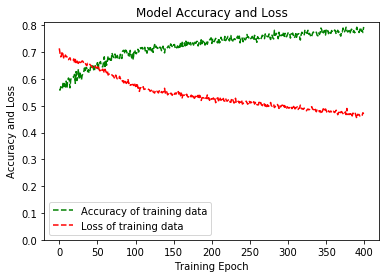

In [50]:
plt.figure(figsize=(6, 4))
plt.plot(cnnhistory.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(cnnhistory.history['loss'], "r--", label="Loss of training data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
